# Jupyter Tutorial for Using SymPy to Produce an Nth-Order Pendulum

In [32]:
# Import Statements
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline

from pylab import *

from sympy import symbols, Dummy, lambdify
from sympy.physics.mechanics import *

from scipy.integrate import odeint

## The Following Code is for a Generalized Pendulum Simulation (Non-Numeric) [Gede et al.]

In [33]:
# Number of pendulums
N = 3

# Create dynamic equations for generalized particle positions and velocities 
q, u = dynamicsymbols("q:{}".format(str(N))), dynamicsymbols("u:{}".format(str(N)))

# Create static constants for pendulum masses and arm lengths
m, l = symbols("m:{}".format(str(N))), symbols("l:{}".format(str(N)))

# Create static constants for gravity and time
g, t = symbols("g t")

# Create inertial reference frame for dynamic motion simulation
frame = ReferenceFrame("frame")
frames = list()

point = Point("point")
point.set_vel(frame, 0)

# Create objects to hold particles, dynamic forces, and kinematic ODEs
particles, forces, kin_odes = list(), list(), list()

# Logic to create N-dulum
for iterator in range(N):
    frame_i = frame.orientnew("frame_{}".format(str(iterator)), "Axis", [q[iterator], frame.z])
    frame_i.set_ang_vel(frame, u[iterator] * frame.z)
    frames.append(frame_i)
    
    point_i = point.locatenew("point_{}".format(str(iterator)), l[iterator] * frame_i.x)
    point_i.v2pt_theory(point, frame, frame_i)
    point_frame_i = Particle("point_frame_{}".format(str(iterator)), point_i, m[iterator])
    particles.append(point_frame_i)
    
    forces.append((point_i, m[iterator] * g * frame.x))
    point = point_i
    
    kin_odes.append(q[iterator].diff(t) - u[iterator])
    
# Test non-numeric N-dulum functionality with Kane's Method
kane = KanesMethod(frame, q_ind=q, u_ind=u, kd_eqs=kin_odes)
fr, frstar = kane.kanes_equations(particles, forces)

## The Following Code Extends the Generalized Simulation into a Numeric Specialized Simulation [Gede et al.]

In [22]:
# Instantiate parametric values needed for inertial reference frame
params = [g]
param_vals = [9.81]

# Initialize parametric reference frame object with pendulum order
for iterator in range(N):
    params += [l[iterator], m[iterator]]
    param_vals += [1./N, 0.01/N]
    
# Create dummy variables for Kane's Method
dummy_symbols = [Dummy() for iterator in q + u]
dummy_dict = dict(zip(q + u, dummy_symbols))

# Create Kane's Method objects for referential analysis
kin_diff_dict = kane.kindiffdict()
mass_matrix = kane.mass_matrix_full.subs(kin_diff_dict).subs(dummy_dict)
full_forcing_vector = kane.forcing_full.subs(kin_diff_dict).subs(dummy_dict)

# Convert Kane's Method entities into NumPy-friendly objects
lambda_mm = lambdify(dummy_symbols + params, mass_matrix)
lambda_ff = lambdify(dummy_symbols + params, full_forcing_vector)

def first_order_equations_of_motions(y, t, args):
    """ Global function to derive 1st-order equations of motion from parametric arguments. """
    seq_args = hstack((y, args))
    return array(linalg.solve(lambda_mm(*seq_args), lambda_ff(*seq_args))).T[0]

# Instantiate variables for derivation of equations of motion
y0 = hstack((arange(N) * 0.01, arange(N) * 0))
t = linspace(0, 10, 1000)

# Derive the Equations of Motion
y = odeint(first_order_equations_of_motions, y0, t, args=(param_vals,))

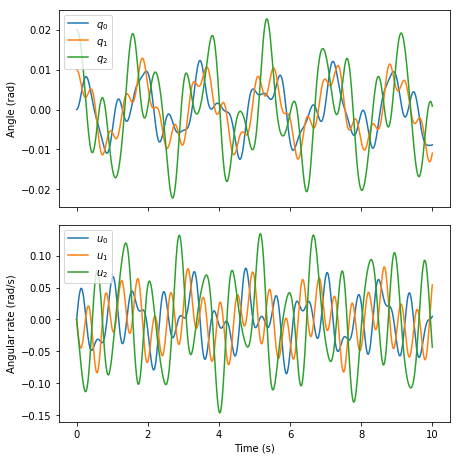

In [24]:
fig, ax = subplots(2, sharex=True, sharey=False)
fig.set_size_inches(6.5, 6.5)

for iterator in range(N):
    ax[0].plot(t, y[:, iterator], label="$q_{}$".format(iterator))
    ax[1].plot(t, y[:, iterator + N], label="$u_{}$".format(iterator))
    
ax[0].legend(loc=0)
ax[1].legend(loc=0)
ax[1].set_xlabel("Time (s)")
ax[0].set_ylabel("Angle (rad)")
ax[1].set_ylabel("Angular rate (rad/s)")

fig.subplots_adjust(hspace=0)
setp(ax[0].get_xticklabels(), visible=False)
tight_layout()
show()

## The Following Code is for a Comprehensive Simulation of an Nth-Order Pendulum

In [117]:
def integrate_pendulum(N, time_vector, 
                       pos_init=135, vel_init=0, 
                       length_vector=None, 
                       mass_vector=1):
    q, u = dynamicsymbols("q:{0}".format(str(N))), dynamicsymbols("u:{0}".format(str(N)))
    m, l = symbols("m:{0}".format(str(N))), symbols("l:{0}".format(str(N)))
    g, t = symbols("g t")
    
    frame = ReferenceFrame("frame")
    point = Point("point")
    point.set_vel(frame, 0)
    particles, forces, kin_odes = list(), list(), list()
        
    for iterator in range(N):
        # Creates reference frame following each iterated mass
        frame_i = frame.orientnew("frame_{}".format(str(iterator)), "Axis", [q[iterator], frame.z])
        frame_i.set_ang_vel(frame, u[iterator] * frame.z)
        # frames.append(frame_i)

        point_i = point.locatenew("point_{}".format(str(iterator)), l[iterator] * frame_i.x)
        point_i.v2pt_theory(point, frame, frame_i)
        
        ref_point_i = Particle("ref_point_{}".format(str(iterator)), point_i, m[iterator])
        particles.append(ref_point_i)

        forces.append((point_i, m[iterator] * g * frame.x))
        kin_odes.append(q[iterator].diff(t) - u[iterator])
        point = point_i
        
    kane = KanesMethod(frame, q_ind=q, u_ind=u, kd_eqs=kin_odes)
    fr, frstar = kane.kanes_equations(particles, forces)
        
    # Numerical Integration
    y0 = np.deg2rad(np.concatenate([np.broadcast_to(pos_init, N), 
                                    np.broadcast_to(vel_init, N)]))
    
    if length_vector is None:
        length_vector = np.ones(N) / N
    length_vector, mass_vector = np.broadcast_to(length_vector, N), np.broadcast_to(mass_vector, N)
    
    params = [g] + list(l) + list(m)
    param_vals = [9.81] + list(length_vector) + list(mass_vector)
    
    dummy_params = [Dummy() for iterator in q + u]
    dummy_dict = dict(zip(q + u, dummy_params))
    
    kin_diff_dict = kane.kindiffdict()
    mass_matrix = kane.mass_matrix_full.subs(kin_diff_dict).subs(dummy_dict)
    full_forcing_vector = kane.forcing_full.subs(kin_diff_dict).subs(dummy_dict)
    
    mm_func = lambdify(dummy_params + params, mass_matrix)
    ff_func = lambdify(dummy_params + params, full_forcing_vector)
    
    def parametric_gradient_function(y, t, args):
        """ Global function to derive 1st-order equations of motion from parametric arguments. """
        values = np.concatenate((y, args))
        solutions = np.linalg.solve(mm_func(*values), ff_func(*values))
        return np.array(solutions).T[0]
    
    return odeint(parametric_gradient_function, y0, time_vector, args=(param_vals,))

In [125]:
def visualize_timewise_displacement(N, time_vector, ap_vector):
    fig, ax = subplots(2, sharex=True, sharey=False)
    fig.set_size_inches(6.5, 6.5)

    for iterator in range(N):
        ax[0].plot(time_vector, ap_vector[:, iterator], label="$q_{}$".format(iterator))
        ax[1].plot(time_vector, ap_vector[:, iterator + N], label="$u_{}$".format(iterator))

    ax[0].legend(loc=0)
    ax[1].legend(loc=0)
    ax[1].set_xlabel("Time (s)")
    ax[0].set_ylabel("Angle (rad)")
    ax[1].set_ylabel("Angular rate (rad/s)")

    fig.subplots_adjust(hspace=0)
    setp(ax[0].get_xticklabels(), visible=False)
    tight_layout()
    show()

In [124]:
def visualize_xy_displacement(ap_vector, length_vector=None):
    """Get (x, y) coordinates from generalized coordinates p"""
    ap_vector = np.atleast_2d(ap_vector)
    n = ap_vector.shape[1] // 2
    
    if length_vector is None:
        length_vector = np.ones(n) / n
        
    zeros_vector = np.zeros(ap_vector.shape[0])[:, None]
    x = np.hstack([zeros_vector, length_vector * np.sin(ap_vector[:, :n])])
    y = np.hstack([zeros_vector, -length_vector * np.cos(ap_vector[:, :n])])
    
    plt.xlabel("X-Position")
    plt.ylabel("Y-Position")
    plt.plot(np.cumsum(x, 1), np.cumsum(y, 1))

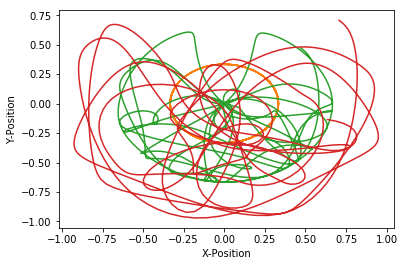

In [134]:
N, time_vector = 3, np.linspace(0, 10, 1000)
ap_vector = integrate_pendulum(N=N, time_vector=time_vector)
visualize_xy_displacement(ap_vector=ap_vector)

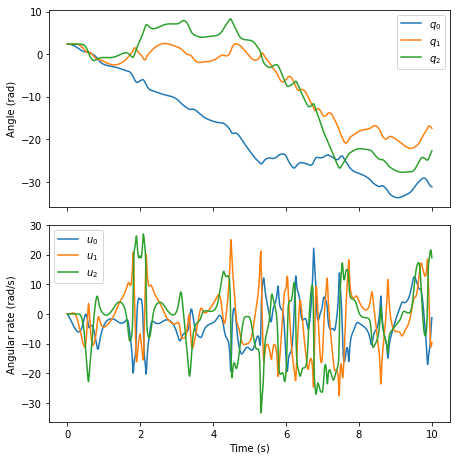

In [135]:
N, time_vector = 3, np.linspace(0, 10, 1000)
ap_vector = integrate_pendulum(N=N, time_vector=time_vector)
visualize_time_series(N=N, time_vector=time_vector, ap_vector=ap_vector)